In [21]:
MODELS_FROM_FILE = 1
IMPORTANCES_FROM_FILE = 1

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")


# Prepare input and ouptut column names

diag_cols = [x for x in item_lvl_w_imp.columns if x.startswith("Diag: ")] # All diagnosis columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]] # Input columns are all columns except Diagnosis, WIAT, and WISC columns

learning_disorder_cols = [
    "Diag: Specific Learning Disorder with Impairment in Reading",
    "Diag: Specific Learning Disorder with Impairment in Mathematics",
    "Diag: Intellectual Disability-Mild",
    "Diag: Borderline Intellectual Functioning",
    "Diag: Specific Learning Disorder with Impairment in Written Expression"
]

# Separate test set for all diagnoses

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [22]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    svc = svm.SVC()
    lr = LogisticRegression(solver="liblinear")
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svc_pipe = make_pipeline(imputer, scaler, svc)
    lr_pipe = make_pipeline(imputer, scaler, lr)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeclassifier__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeclassifier__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeclassifier__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeclassifier__max_leaf_nodes": np.random.randint(2, 50, 30),
        "decisiontreeclassifier__criterion": ['gini', 'entropy'],
        "decisiontreeclassifier__class_weight": ['balanced', None]
    }
    rf_param_grid = {
        'randomforestclassifier__max_depth' : np.random.randint(5, 150, 30),
        'randomforestclassifier__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestclassifier__n_estimators': np.random.randint(50, 400, 10),
        'randomforestclassifier__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__class_weight':["balanced", "balanced_subsample", None],
        "randomforestclassifier__class_weight": ['balanced', None]
    }
    svc_param_grid = {
        'svc__C': loguniform(1e-03, 1e+02),
        'svc__gamma': loguniform(1e-03, 1e+02),
        'svc__degree': uniform(2, 5),
        'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        "svc__class_weight": ['balanced', None]
    }
    lr_param_grid = {
        'logisticregression__C': loguniform(1e-5, 100),
        'logisticregression__penalty': ['l1', 'l2']
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svc_pipe, svc_param_grid),
        (lr_pipe, lr_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    cv = StratifiedKFold(n_splits=3)
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=cv, scoring="roc_auc", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    # If chosen model is SVM add a predict_proba parameter (not needed for grid search, and slows it down significantly)
    if 'svc' in best_estimator.named_steps.keys():
        best_estimator.set_params(svc__probability=True)

    return (best_estimator, best_score)

In [23]:
# Calculate probability threshold
beta = 2.5
def calculate_threshold(classifier, output_col, b = beta):
    from numpy import nanargmax
    
    # Fit model on validation set
    classifier.fit(train_train_set[input_cols], train_train_set[output_col])
    
    # Get predicted probabilities values
    y_val_pred_prob = classifier.predict_proba(val_set[input_cols])
    
    # Calculate precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(val_set[output_col], y_val_pred_prob[:,1])
    
    # Calculate F-scores
    fscores = ((1+b**2) * precisions * recalls) / ((b**2 * precisions) + recalls)
    
    # Locate the index of the largest F-score
    ix = nanargmax(fscores)
    
    threshold = thresholds[ix]
    
    return threshold

In [24]:
def find_best_classifier_for_diag(diag):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, diag)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [25]:
# Check how many diagnoses passed the threshold of 50 positive cases
counter = 0
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        counter += 1
print("Diagnoses with over 50 positive cases: ", counter)

# Check which learning diagnoses didn't pass threshold of 50 positive cases
print("Learning diagnoses with over 50 positive cases: ")
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() <= 50 and diag in learning_disorder_cols:
        print(diag)      

Diagnoses with over 50 positive cases:  21
Learning diagnoses with over 50 positive cases: 
Diag: Intellectual Disability-Mild
Diag: Borderline Intellectual Functioning


In [26]:
if MODELS_FROM_FILE == 0:
    best_classifiers = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = find_best_classifier_for_diag(diag)
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_classifiers[diag] = (best_classifier_for_diag, threshold)
    print(best_classifiers)

In [27]:
# Find best thresholds
def find_best_thresholds(beta=beta):
    best_thresholds = {}
    for diag in diag_cols:
        if item_lvl_w_imp[diag].sum() > 50: # Don't use diagnoses if there are less than 50 positive examples
            best_classifier_for_diag = best_classifiers[diag][0]
            threshold = calculate_threshold(best_classifier_for_diag, diag, beta)
            best_thresholds[diag] = threshold
    print(best_thresholds)
    return best_thresholds

if MODELS_FROM_FILE == 0:
    best_thresholds = find_best_thresholds(beta=beta)

In [28]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best classifiers and thresholds - best parameters, and the classifyer objects themselves
    best_classifiers_df = pd.DataFrame(best_classifiers).T.reset_index()
    best_classifiers_df.columns = ["Diag", "Best Estimator", "Best Threshold"]
    display(best_classifiers_df)
    best_classifiers_df.to_csv("best-estimators-diag-item-lvl.csv")

    dump(best_classifiers, 'best-classifiers-diag-item-lvl.joblib', compress=1)
    dump(best_thresholds, 'best-thresholds-diag-item-lvl.joblib', compress=1)

In [29]:
if MODELS_FROM_FILE == 1:
    best_classifiers = load('best-classifiers-diag-item-lvl.joblib')
    best_thresholds = load('best-thresholds-diag-item-lvl.joblib')

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using versi

In [30]:
import math
metric_names = ['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','FDR','FOR','check_Pos','check_Neg','Recall','FPR','FNR','TNR','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK']   
def get_matrix_metrics(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]+0.01 # +0.01 To avoid division by 0 errors
    FN = CM[1][0]+0.01
    TP = CM[1][1]+0.01
    FP = CM[0][1]+0.01
    Population = TN+FN+TP+FP
    Prevalence = round( (TP+FP) / Population,2)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    NPV        = round( TN / (TN+FN),4 )
    FDR        = round( FP / (TP+FP),4 )
    FOR        = round( FN / (TN+FN),4 ) 
    check_Pos  = Precision + FDR
    check_Neg  = NPV + FOR
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    FNR        = round( FN / (TP+FN),4 )
    TNR        = round( TN / (TN+FP),4 ) 
    check_Pos2 = Recall + FNR
    check_Neg2 = FPR + TNR
    LRPos      = round( Recall/FPR,4 ) 
    LRNeg      = round( FNR / TNR ,4 )
    DOR        = round( LRPos/LRNeg)
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    BM         = Recall+TNR-1
    MK         = Precision+NPV-1   
    
    mat_met = [TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]
    return (mat_met)

In [31]:
def get_metrics(classifier, threshold, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred_prob = classifier.predict_proba(x)
    y_pred = (y_pred_prob[:,1] >= threshold).astype(bool) 
    
    roc_auc = roc_auc_score(y, y_pred_prob[:,1])
    
    metrics = get_matrix_metrics(y, y_pred, beta=3)
    metrics.append(roc_auc)
    
    if print_output_flag:
        print(output_col)
        
        # Display confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

        # Display the ROC curve 
        fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, marker='.', label='Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    return metrics

Diag: Major Depressive Disorder


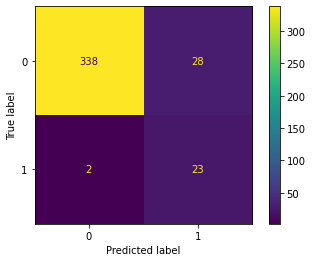

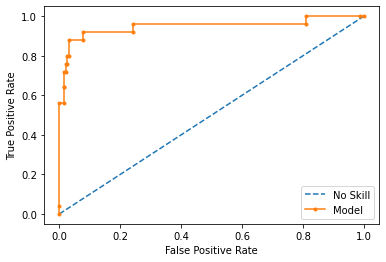

Diag: Persistent (Chronic) Motor or Vocal Tic Disorder


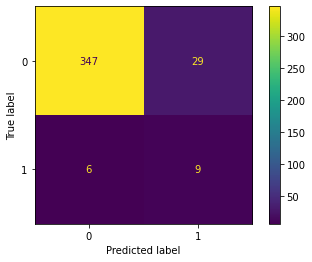

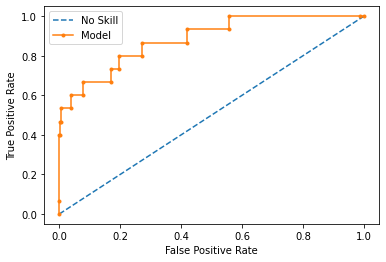

Diag: Social Anxiety (Social Phobia)


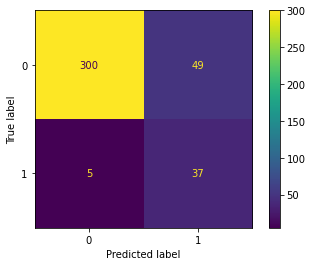

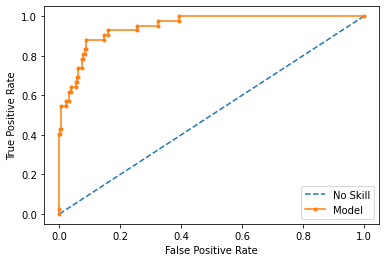

Diag: Speech Sound Disorder


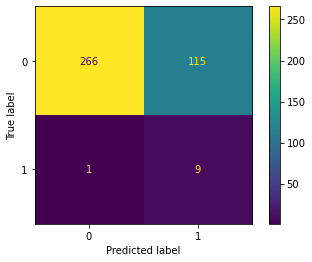

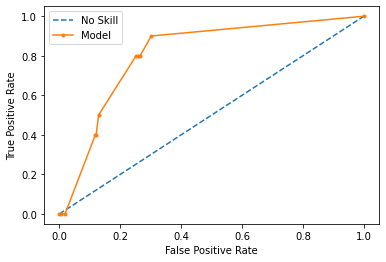

Diag: ADHD-Inattentive Type


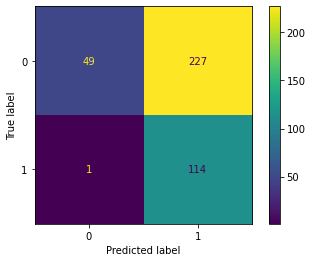

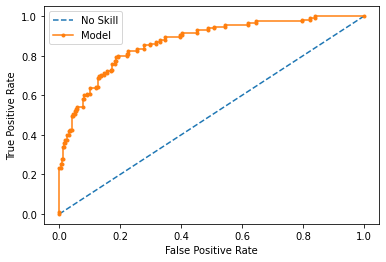

Diag: Generalized Anxiety Disorder


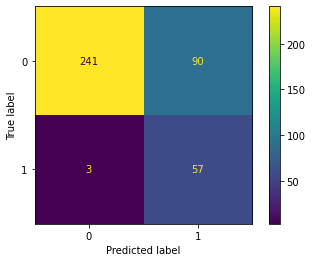

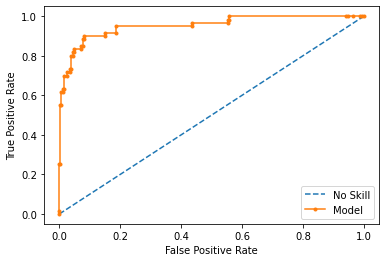

Diag: Separation Anxiety


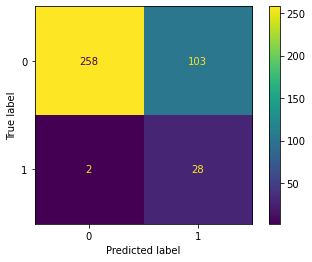

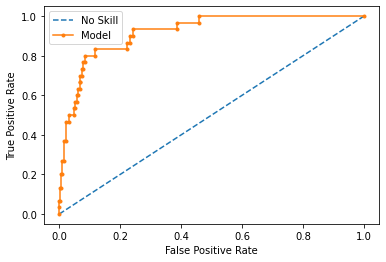

Diag: ADHD-Combined Type


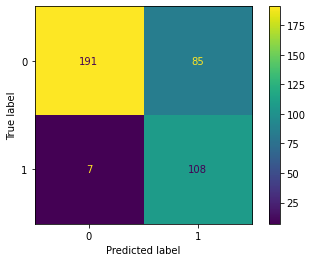

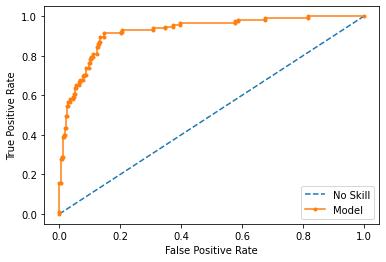

Diag: Enuresis


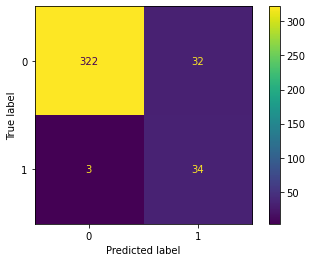

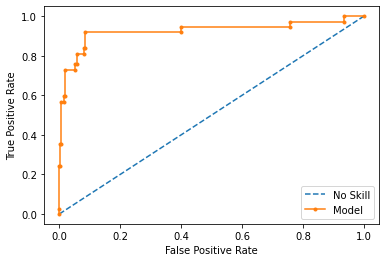

Diag: Specific Learning Disorder with Impairment in Mathematics


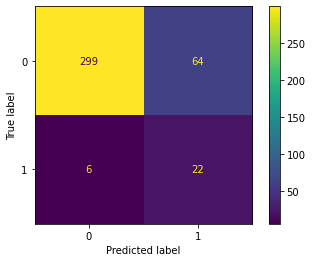

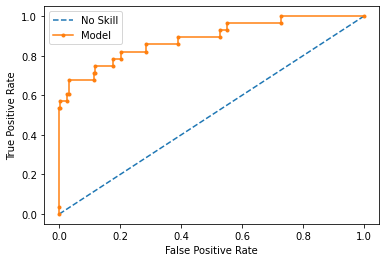

Diag: Specific Learning Disorder with Impairment in Reading


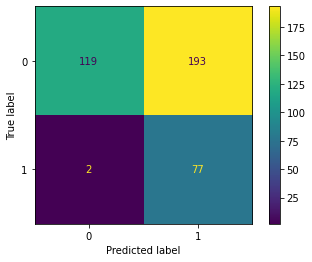

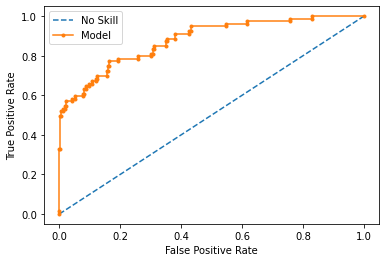

Diag: Oppositional Defiant Disorder


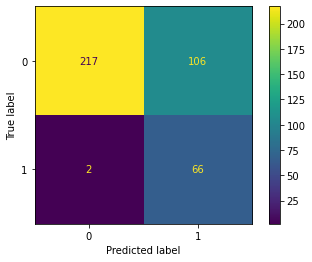

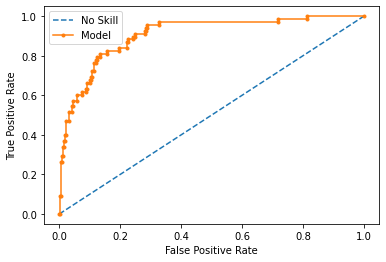

Diag: Obsessive-Compulsive Disorder


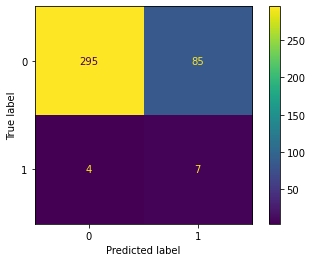

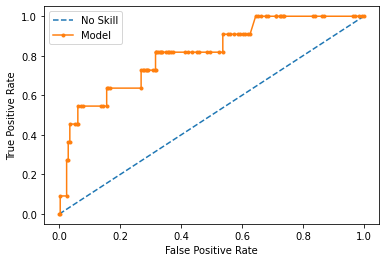

Diag: ADHD-Hyperactive/Impulsive Type


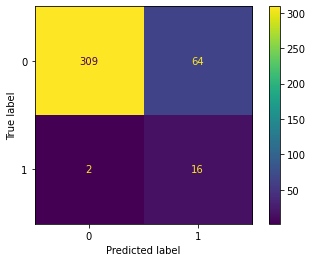

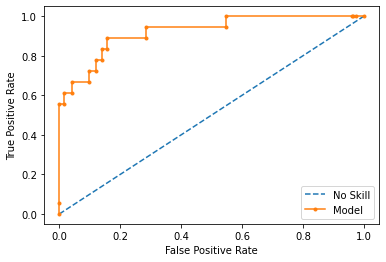

Diag: Specific Learning Disorder with Impairment in Written Expression


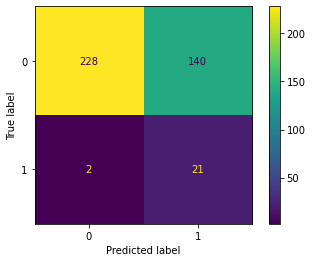

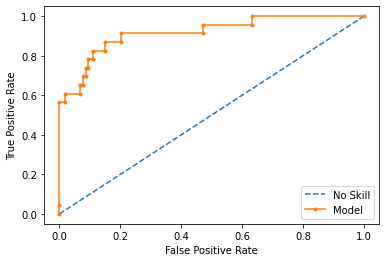

Diag: Language Disorder


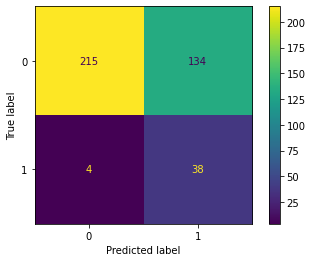

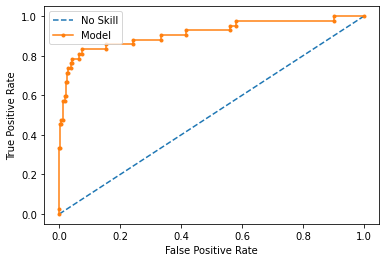

Diag: Other Specified Attention-Deficit/Hyperactivity Disorder


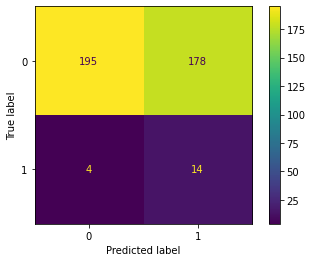

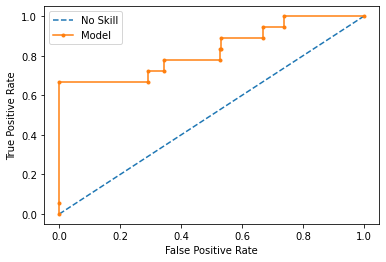

Diag: No Diagnosis Given


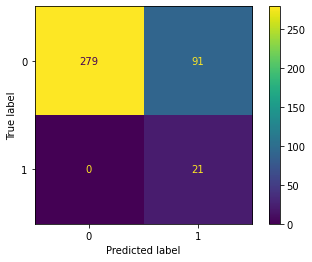

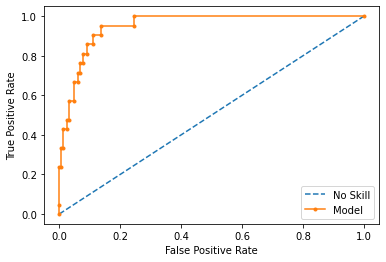

Diag: Autism Spectrum Disorder


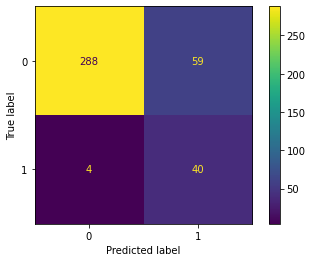

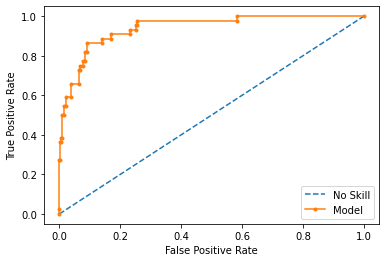

Diag: Specific Phobia


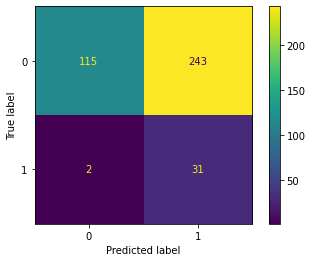

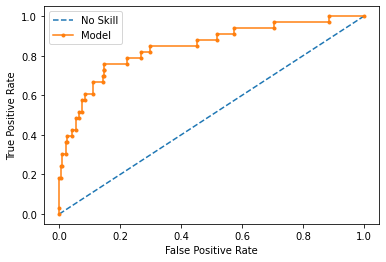

Diag: Other Specified Anxiety Disorder


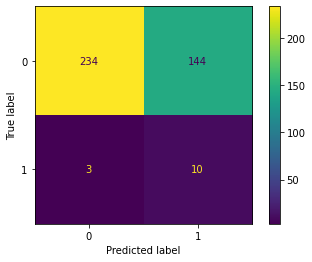

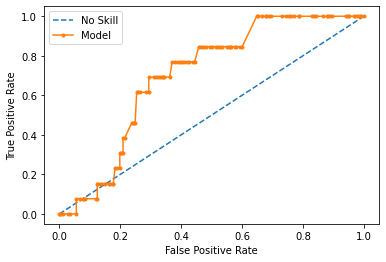

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC
5,Diag: Generalized Anxiety Disorder,57.01,241.01,90.01,3.01,0.38,0.7621,0.3878,0.9877,0.6122,0.0123,1.0,1.0,0.9499,0.2719,0.0501,0.7281,1.0,1.0,3.4936,0.0688,51,0.5508,0.8296,0.5045,0.6780,0.3755,0.952719
17,Diag: No Diagnosis Given,21.01,279.01,91.01,0.01,0.29,0.7672,0.1876,1.0000,0.8124,0.0000,1.0,1.0,0.9995,0.2460,0.0005,0.7540,1.0,1.0,4.0630,0.0007,5804,0.3159,0.6976,0.3759,0.7535,0.1876,0.951995
2,Diag: Social Anxiety (Social Phobia),37.01,300.01,49.01,5.01,0.22,0.8619,0.4302,0.9836,0.5698,0.0164,1.0,1.0,0.8808,0.1404,0.1192,0.8596,1.0,1.0,6.2735,0.1387,45,0.5781,0.7973,0.5535,0.7404,0.4138,0.948833
0,Diag: Major Depressive Disorder,23.01,338.01,28.01,2.01,0.13,0.9232,0.4510,0.9941,0.5490,0.0059,1.0,1.0,0.9197,0.0765,0.0803,0.9235,1.0,1.0,12.0222,0.0870,138,0.6052,0.8331,0.6126,0.8432,0.4451,0.948306
18,Diag: Autism Spectrum Disorder,40.01,288.01,59.01,4.01,0.25,0.8388,0.4041,0.9863,0.5959,0.0137,1.0,1.0,0.9089,0.1700,0.0911,0.8300,1.0,1.0,5.3465,0.1098,49,0.5595,0.8080,0.5370,0.7389,0.3904,0.941708
8,Diag: Enuresis,34.01,322.01,32.01,3.01,0.17,0.9104,0.5151,0.9907,0.4849,0.0093,1.0,1.0,0.9187,0.0904,0.0813,0.9096,1.0,1.0,10.1626,0.0894,114,0.6601,0.8519,0.6473,0.8283,0.5058,0.925790
7,Diag: ADHD-Combined Type,108.01,191.01,85.01,7.01,0.49,0.7647,0.5596,0.9646,0.4404,0.0354,1.0,1.0,0.9391,0.3080,0.0609,0.6920,1.0,1.0,3.0490,0.0880,35,0.7013,0.8795,0.5751,0.6311,0.5242,0.923819
13,Diag: ADHD-Hyperactive/Impulsive Type,16.01,309.01,64.01,2.01,0.20,0.8312,0.2001,0.9935,0.7999,0.0065,1.0,1.0,0.8885,0.1716,0.1115,0.8284,1.0,1.0,5.1777,0.1346,38,0.3266,0.6611,0.3725,0.7169,0.1936,0.922252
6,Diag: Separation Anxiety,28.01,258.01,103.01,2.01,0.34,0.7314,0.2138,0.9923,0.7862,0.0077,1.0,1.0,0.9330,0.2853,0.0670,0.7147,1.0,1.0,3.2702,0.0937,35,0.3479,0.6981,0.3653,0.6477,0.2061,0.919206
14,Diag: Specific Learning Disorder with Impairment in Written Expression,21.01,228.01,140.01,2.01,0.41,0.6368,0.1305,0.9913,0.8695,0.0087,1.0,1.0,0.9127,0.3804,0.0873,0.6196,1.0,1.0,2.3993,0.1409,17,0.2283,0.5707,0.2546,0.5323,0.1218,0.916942


In [32]:
# Check performance of the final model on validation set for all models

results_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'validation', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_val_set.append([
            diag, 
            *metrics])
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_val_set_df.sort_values(by="ROC AUC", ascending=False)

In [43]:
# Do cross-validation to get more reliable ROC AUC scores (f1 harder to obtain with cross validation - need to change threshold)

auc_cv_mean_val_set = []
auc_cv_std_val_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        
        cv = StratifiedKFold(n_splits=5)
        auc = cross_val_score(classifier, train_set[input_cols], train_set[diag], cv=cv, scoring='roc_auc', n_jobs=-1)
        
        auc_cv_mean_val_set.append(auc.mean())
        auc_cv_std_val_set.append(auc.std())
restults_val_set_df["ROC AUC Mean CV"] = pd.Series(auc_cv_mean_val_set)
restults_val_set_df["ROC AUC Std CV"] = pd.Series(auc_cv_std_val_set)
restults_val_set_df

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/impute/_base.py:337: Fut

,Diag,TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LR+,LR-,DOR,F1,FBeta,MCC,BM,MK,ROC AUC,ROC AUC Mean CV,ROC AUC Std CV
0,Diag: Major Depressive Disorder,23.01,338.01,28.01,2.01,0.13,0.9232,0.4510,0.9941,0.5490,0.0059,1.0,1.0,0.9197,0.0765,0.0803,0.9235,1.0,1.0,12.0222,0.0870,138,0.6052,0.8331,0.6126,0.8432,0.4451,0.948306,0.888362,0.017696
1,Diag: Persistent (Chronic) Motor or Vocal Tic Disorder,9.01,347.01,29.01,6.01,0.10,0.9104,0.2370,0.9830,0.7630,0.0170,1.0,1.0,0.5999,0.0772,0.4001,0.9228,1.0,1.0,7.7707,0.4336,18,0.3398,0.5202,0.3391,0.5227,0.2200,0.884220,0.784302,0.068264
2,Diag: Social Anxiety (Social Phobia),37.01,300.01,49.01,5.01,0.22,0.8619,0.4302,0.9836,0.5698,0.0164,1.0,1.0,0.8808,0.1404,0.1192,0.8596,1.0,1.0,6.2735,0.1387,45,0.5781,0.7973,0.5535,0.7404,0.4138,0.948833,0.828181,0.027100
3,Diag: Speech Sound Disorder,9.01,266.01,115.01,1.01,0.32,0.7033,0.0726,0.9962,0.9274,0.0038,1.0,1.0,0.8992,0.3018,0.1008,0.6982,1.0,1.0,2.9795,0.1444,21,0.1344,0.4205,0.2028,0.5974,0.0688,0.809711,0.756100,0.040006
4,Diag: ADHD-Inattentive Type,114.01,49.01,227.01,1.01,0.87,0.4169,0.3343,0.9798,0.6657,0.0202,1.0,1.0,0.9912,0.8224,0.0088,0.1776,1.0,1.0,1.2053,0.0495,24,0.5000,0.8284,0.2303,0.1688,0.3141,0.870542,0.785288,0.023320
5,Diag: Generalized Anxiety Disorder,57.01,241.01,90.01,3.01,0.38,0.7621,0.3878,0.9877,0.6122,0.0123,1.0,1.0,0.9499,0.2719,0.0501,0.7281,1.0,1.0,3.4936,0.0688,51,0.5508,0.8296,0.5045,0.6780,0.3755,0.952719,0.849129,0.033325
6,Diag: Separation Anxiety,28.01,258.01,103.01,2.01,0.34,0.7314,0.2138,0.9923,0.7862,0.0077,1.0,1.0,0.9330,0.2853,0.0670,0.7147,1.0,1.0,3.2702,0.0937,35,0.3479,0.6981,0.3653,0.6477,0.2061,0.919206,0.781766,0.036200
7,Diag: ADHD-Combined Type,108.01,191.01,85.01,7.01,0.49,0.7647,0.5596,0.9646,0.4404,0.0354,1.0,1.0,0.9391,0.3080,0.0609,0.6920,1.0,1.0,3.0490,0.0880,35,0.7013,0.8795,0.5751,0.6311,0.5242,0.923819,0.872438,0.015119
8,Diag: Enuresis,34.01,322.01,32.01,3.01,0.17,0.9104,0.5151,0.9907,0.4849,0.0093,1.0,1.0,0.9187,0.0904,0.0813,0.9096,1.0,1.0,10.1626,0.0894,114,0.6601,0.8519,0.6473,0.8283,0.5058,0.925790,0.880219,0.038540
9,Diag: Specific Learning Disorder with Impairment in Mathematics,22.01,299.01,64.01,6.01,0.22,0.8209,0.2559,0.9803,0.7441,0.0197,1.0,1.0,0.7855,0.1763,0.2145,0.8237,1.0,1.0,4.4555,0.2604,17,0.3860,0.6508,0.3793,0.6092,0.2362,0.886462,0.755847,0.025683


In [44]:
# # Check cross-validation performance of the final model on validation set for all models to check for overfitting

# def plot_test_vs_train_scores(cv_results):
#     scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
#     display(scores)
#     scores.plot.hist(bins=50)
#     plt.xlim(0, 1)
#     plt.show()

# results_val_set = []
# for output in best_classifiers.keys():
#     print(output)
#     cv = StratifiedKFold(n_splits=5)
#     estimator = best_classifiers[output][0]
#     cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True, cv=cv, scoring='roc_auc')
#     metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
#     results_val_set.append([
#         output, 
#         *metrics])
    
#     plot_test_vs_train_scores(cv_results)
# restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
# restults_val_set_df

In [ ]:
# Check why Enuresis is so low
diag = "Diag: Enuresis"

## Are there rows where Diag=0 if among "CBCL,CBCL_108", "SympChck,CSC_28P", "SympChck,CSC_28C" at least one is 1
print(len(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]][(item_lvl_w_imp["Diag: Enuresis"] == 0) & ((item_lvl_w_imp[["CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]] > 0).any(axis=1))].index), " / ", len(item_lvl_w_imp[item_lvl_w_imp["Diag: Enuresis"] == 0].index))

## Are there rows where Diag=1 if all "CBCL,CBCL_108", "SympChck,CSC_28P", "SympChck,CSC_28C" = 0
print(len(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]][(item_lvl_w_imp["Diag: Enuresis"] == 1) & (item_lvl_w_imp[["CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]] == 0).all(axis=1)]), " / ", len(item_lvl_w_imp[item_lvl_w_imp["Diag: Enuresis"] == 1].index))

# ==> More than a quarter positive diagnoses answered two main items negatively, lower performance is expected

display(item_lvl_w_imp[["Diag: Enuresis", "CBCL,CBCL_107", "CBCL,CBCL_108", "SympChck,CSC_28C"]].corr())

In [ ]:
# Check performance of the final model on test set for all models

results_test_set = []
for diag in diag_cols:
    if item_lvl_w_imp[diag].sum() > 50:
        classifier = best_classifiers[diag][0]
        threshold = best_thresholds[diag]
        metrics = get_metrics(classifier, threshold, diag, input_cols, 'test', 1)
        prevalence = item_lvl_w_imp[diag].sum()/len(item_lvl_w_imp)
        results_test_set.append([
            diag, 
            *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Diag"]+metric_names+["ROC AUC"])
restults_test_set_df

### Feature importance

In [46]:
# Only use well performing diagnoses for feature selection: with (Mean CV AUC - CV AUC Std) > 0.65 and F1 Beta > 0.5

diags_with_good_performance = list(restults_val_set_df[((restults_val_set_df["ROC AUC Mean CV"] - restults_val_set_df["ROC AUC Std CV"])>0.65) & (restults_val_set_df["FBeta"] > 0.5)]["Diag"])
display(diags_with_good_performance)
len(diags_with_good_performance)

['Diag: Major Depressive Disorder',
 'Diag: Persistent (Chronic) Motor or Vocal Tic Disorder',
 'Diag: Social Anxiety (Social Phobia)',
 'Diag: ADHD-Inattentive Type',
 'Diag: Generalized Anxiety Disorder',
 'Diag: Separation Anxiety',
 'Diag: ADHD-Combined Type',
 'Diag: Enuresis',
 'Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Specific Learning Disorder with Impairment in Reading',
 'Diag: Oppositional Defiant Disorder',
 'Diag: ADHD-Hyperactive/Impulsive Type',
 'Diag: Language Disorder',
 'Diag: No Diagnosis Given',
 'Diag: Autism Spectrum Disorder',
 'Diag: Specific Phobia']

16

In [47]:
learning_diag_w_good_performance = [x for x in diags_with_good_performance if x in learning_disorder_cols]
learning_diag_w_good_performance

['Diag: Specific Learning Disorder with Impairment in Mathematics',
 'Diag: Specific Learning Disorder with Impairment in Reading']

In [36]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-diag-item-lvl.joblib')
    except Exception as e: print(e)

/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/charlie/opt/anaconda3/envs/main/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using versi

In [37]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["ROC AUC"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["ROC AUC"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

In [38]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for diag in set(diags_with_good_performance[0:3] + learning_diag_w_good_performance): # First 3 + all learning
        print(diag)
        diag_classifier = best_classifiers[diag][0]

        cv = StratifiedKFold(n_splits=3)
        sfs = SequentialFeatureSelector(diag_classifier, 
              k_features=100,
              forward=True, 
              scoring='roc_auc',
              cv=cv,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[diag])

        forward_feature_subsets[diag] = sfs.subsets_
        forward_feature_objects[diag] = sfs
        
        analyze_importances(forward_feature_objects[diag].subsets_)

In [39]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-diag-item-lvl.joblib', compress=1)

In [41]:
forward_feature_objects.keys()

dict_keys(['Diag: No Diagnosis Given', 'Diag: Obsessive-Compulsive Disorder', 'Diag: Oppositional Defiant Disorder', 'Diag: Specific Learning Disorder with Impairment in Mathematics', 'Diag: Major Depressive Disorder'])

Diag: No Diagnosis Given


,ROC AUC
1,0.750570
2,0.792343
3,0.810844
4,0.827227
5,0.838519
...,...
96,0.866672
97,0.864790
98,0.865788
99,0.865854


Max score:  0.8846257290074174  at  49  features


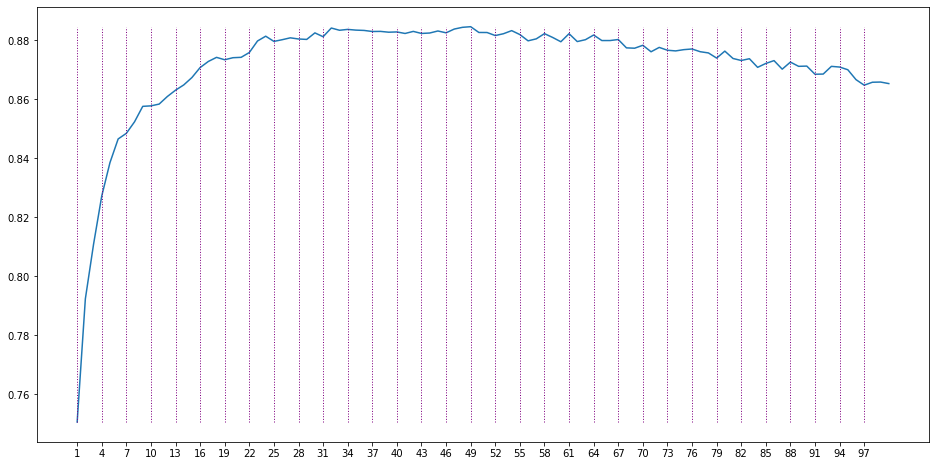

Optimal number of features:  24


('SympChck,CSC_18P',
 'SympChck,CSC_28P',
 'SympChck,CSC_55hP',
 'SCQ,SCQ_06',
 'SCQ,SCQ_40',
 'SDQ,SDQ_16',
 'SDQ,SDQ_29_b',
 'SDQ,SDQ_29_c',
 'SRS,SRS_01',
 'SRS,SRS_03',
 'SRS,SRS_36',
 'SRS,SRS_61',
 'CBCL,CBCL_100',
 'CBCL,CBCL_53',
 'ICU_P,ICU_P_14',
 'ICU_P,ICU_P_24',
 'APQ_P,APQ_P_35',
 'ESWAN,MDD_8A',
 'ESWAN,SocAnx_05',
 'APQ_SR,APQ_SR_06',
 'APQ_SR,APQ_SR_13',
 'APQ_SR,APQ_SR_14A',
 'APQ_SR,APQ_SR_31',
 'CIS_SR,CIS_SR_06')

Score using all features: 
Diag: No Diagnosis Given


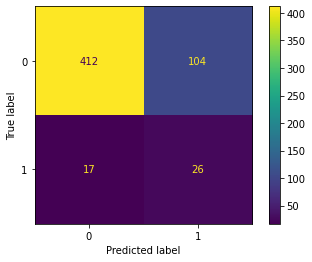

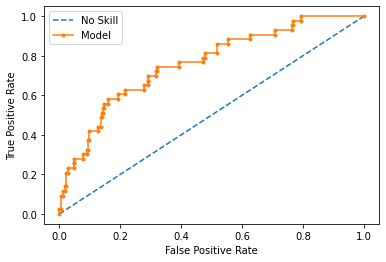

ROC AUC:  0.7611772129078781
Recall:  0.6046
Precision:  0.2
Performance on test set using optimal number of columns: 
Diag: No Diagnosis Given


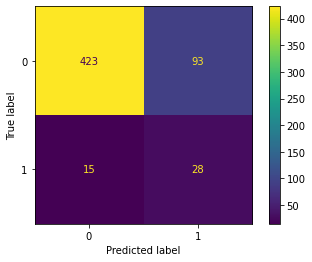

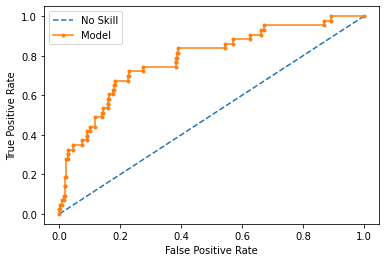

ROC AUC:  0.7840724716062737
Recall:  0.6511
Precision:  0.2314
Performance on test set using number of columns with maximum score
Diag: No Diagnosis Given


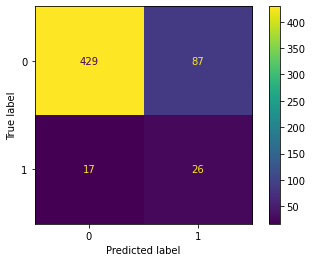

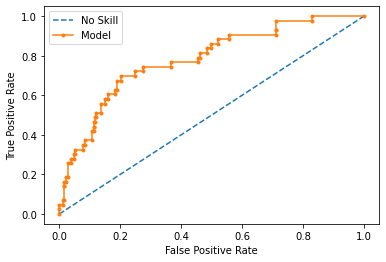

ROC AUC:  0.7828555976203353
Recall:  0.6046
Precision:  0.2301
Diag: Obsessive-Compulsive Disorder


,ROC AUC
1,0.756249
2,0.848357
3,0.870545
4,0.887631
5,0.889248
...,...
96,0.891394
97,0.891394
98,0.891394
99,0.891394


Max score:  0.8913938452601937  at  10  features


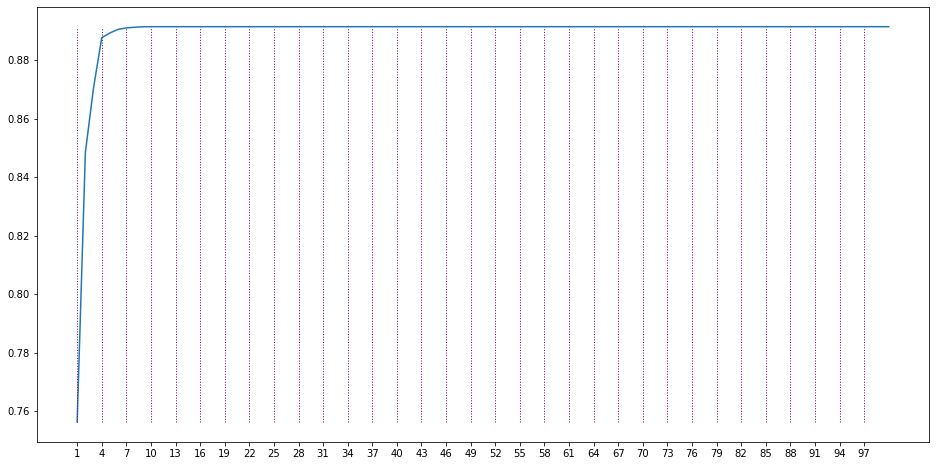

Optimal number of features:  5


('SympChck,CSC_26P',
 'SympChck,CSC_27P',
 'CBCL,CBCL_112',
 'CBCL,CBCL_66',
 'CBCL,CBCL_84')

Score using all features: 
Diag: Obsessive-Compulsive Disorder


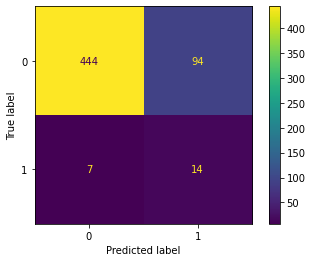

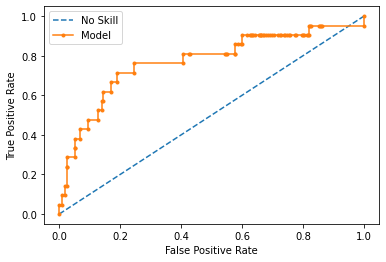

ROC AUC:  0.7725261108160736
Recall:  0.6665
Precision:  0.1297
Performance on test set using optimal number of columns: 
Diag: Obsessive-Compulsive Disorder


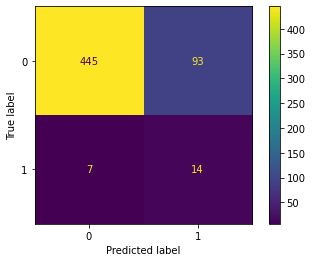

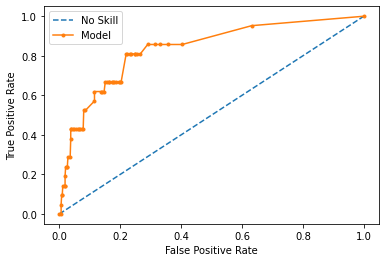

ROC AUC:  0.8342184457426093
Recall:  0.6665
Precision:  0.1309
Performance on test set using number of columns with maximum score
Diag: Obsessive-Compulsive Disorder


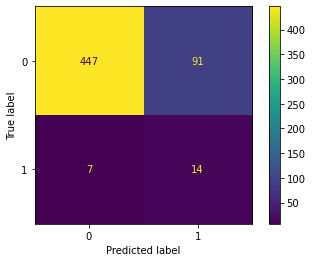

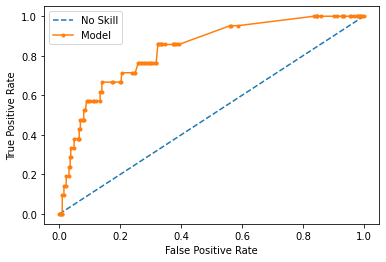

ROC AUC:  0.8311205523101434
Recall:  0.6665
Precision:  0.1334
Diag: Oppositional Defiant Disorder


,ROC AUC
1,0.807244
2,0.844964
3,0.861169
4,0.873248
5,0.878969
...,...
96,0.904491
97,0.904349
98,0.905006
99,0.904961


Max score:  0.9064535284047478  at  73  features


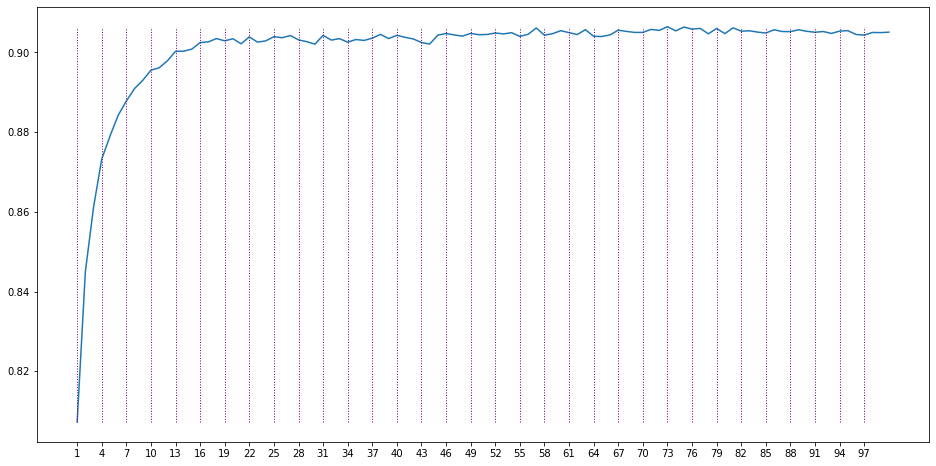

Optimal number of features:  13


('SympChck,CSC_39P',
 'ARI_P,ARI_P_05',
 'SRS,SRS_53',
 'CBCL,CBCL_112',
 'CBCL,CBCL_22',
 'CBCL,CBCL_56D',
 'ICU_P,ICU_P_04',
 'ESWAN,DMDD_3B',
 'APQ_SR,APQ_SR_10',
 'APQ_SR,APQ_SR_26',
 'CIS_P,CIS_P_13',
 'WHODAS_SR,WHODAS_SR_11',
 'APQ_SR,APQ_SR_07A_WAS_MISSING')

Score using all features: 
Diag: Oppositional Defiant Disorder


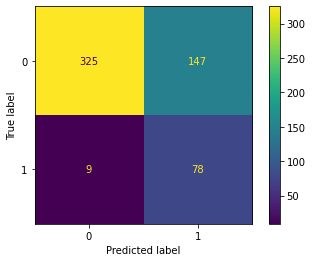

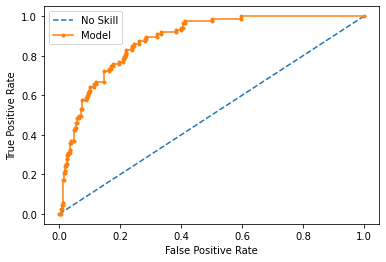

ROC AUC:  0.8816481589713618
Recall:  0.8965
Precision:  0.3467
Performance on test set using optimal number of columns: 
Diag: Oppositional Defiant Disorder


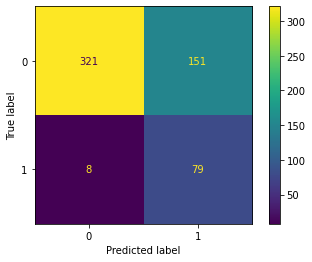

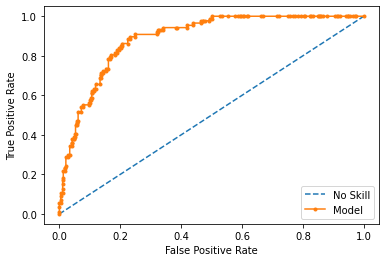

ROC AUC:  0.8900618546658874
Recall:  0.908
Precision:  0.3435
Performance on test set using number of columns with maximum score
Diag: Oppositional Defiant Disorder


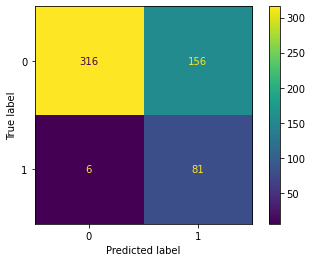

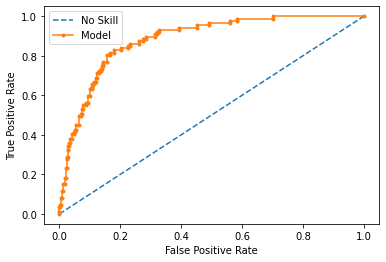

ROC AUC:  0.883815507500487
Recall:  0.9309
Precision:  0.3418
Diag: Specific Learning Disorder with Impairment in Mathematics


,ROC AUC
1,0.634319
2,0.675166
3,0.704033
4,0.727475
5,0.748643
...,...
96,0.844874
97,0.844967
98,0.845581
99,0.846751


Max score:  0.853096617063488  at  63  features


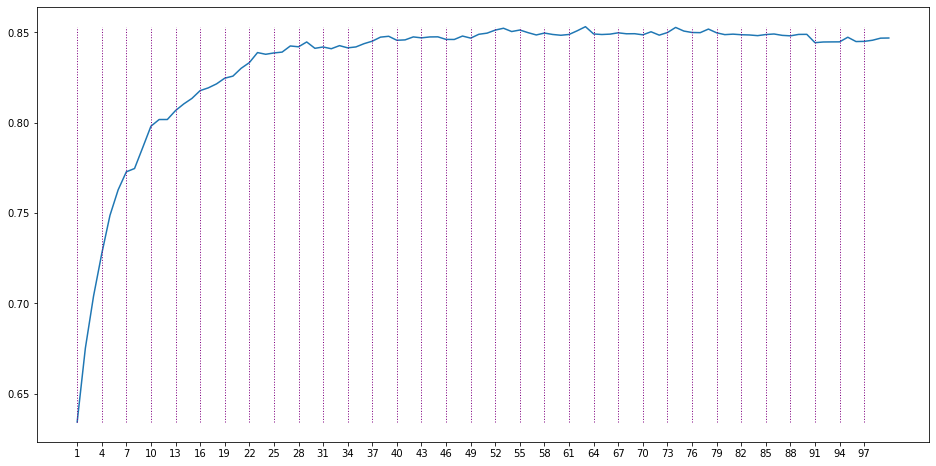

Optimal number of features:  23


('SympChck,CSC_01P',
 'SympChck,CSC_02C',
 'SympChck,CSC_42P',
 'SCQ,SCQ_19',
 'SCQ,SCQ_32',
 'SCQ,SCQ_35',
 'ASSQ,ASSQ_03',
 'ASSQ,ASSQ_13',
 'SDQ,SDQ_09',
 'SWAN,SWAN_08',
 'CBCL,CBCL_47',
 'CBCL,CBCL_60',
 'APQ_P,APQ_P_21',
 'APQ_P,APQ_P_28',
 'DTS,DTS_08',
 'ESWAN,DMDD_2A',
 'ESWAN,DMDD_2B',
 'ESWAN,DMDD_5B',
 'WHODAS_P,WHODAS_P_Days02',
 'PSI,PSI_18',
 'RBS,RBS_18',
 'RBS,RBS_25',
 'WHODAS_SR,WHODAS_SR_Days03')

Score using all features: 
Diag: Specific Learning Disorder with Impairment in Mathematics


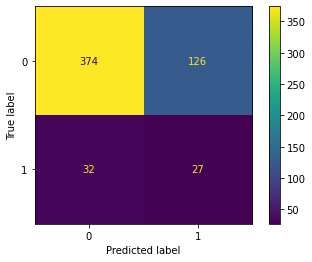

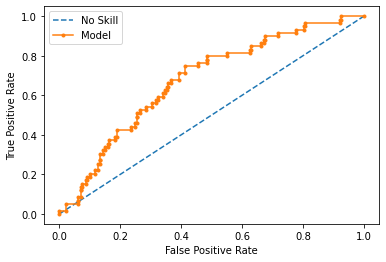

ROC AUC:  0.6781016949152543
Recall:  0.4576
Precision:  0.1765
Performance on test set using optimal number of columns: 
Diag: Specific Learning Disorder with Impairment in Mathematics


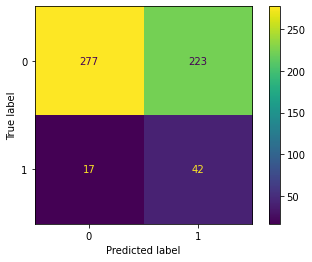

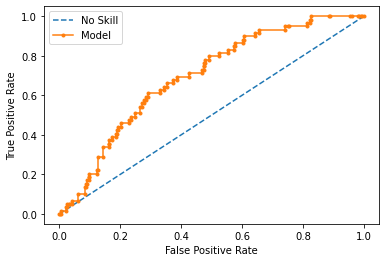

ROC AUC:  0.6950847457627118
Recall:  0.7118
Precision:  0.1585
Performance on test set using number of columns with maximum score
Diag: Specific Learning Disorder with Impairment in Mathematics


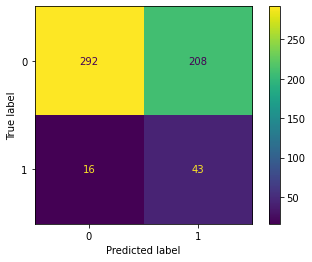

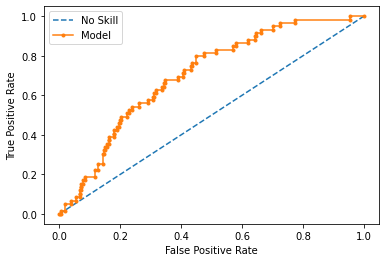

ROC AUC:  0.7042372881355933
Recall:  0.7287
Precision:  0.1713
Diag: Major Depressive Disorder


,ROC AUC
1,0.768799
2,0.831444
3,0.870064
4,0.882773
5,0.895243
...,...
96,0.913341
97,0.911948
98,0.911485
99,0.909628


Max score:  0.921038157002699  at  42  features


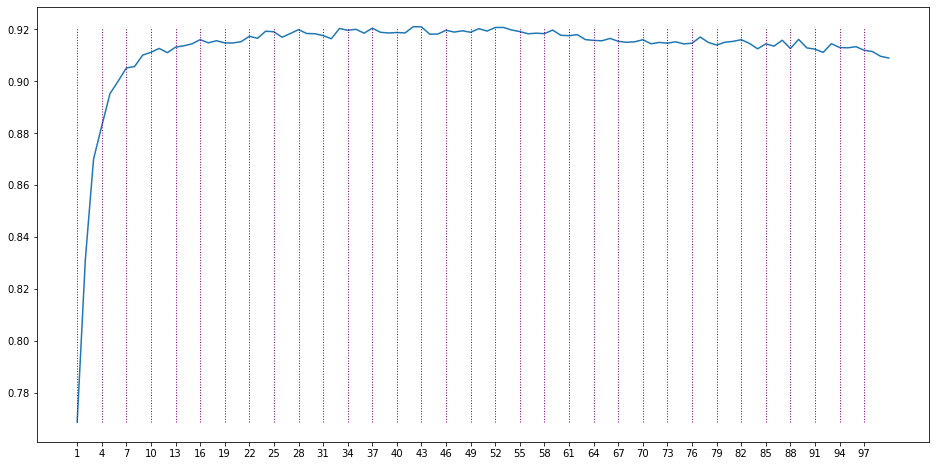

Optimal number of features:  9


('Basic_Demos,Age',
 'SympChck,CSC_01P',
 'SympChck,CSC_03P',
 'SympChck,CSC_49C',
 'SympChck,CSC_49P',
 'SRS,SRS_37',
 'CBCL,CBCL_103',
 'APQ_SR,APQ_SR_09',
 'APQ_SR,APQ_SR_26')

Score using all features: 
Diag: Major Depressive Disorder


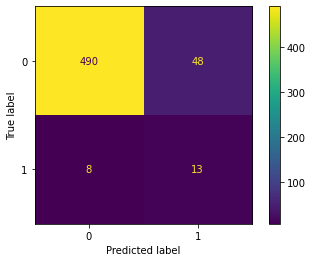

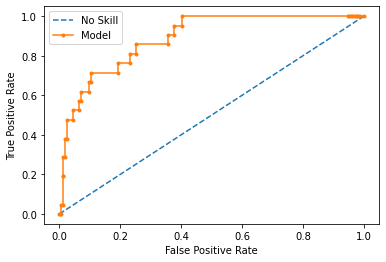

ROC AUC:  0.8888298813949372
Recall:  0.6189
Precision:  0.2132
Performance on test set using optimal number of columns: 
Diag: Major Depressive Disorder


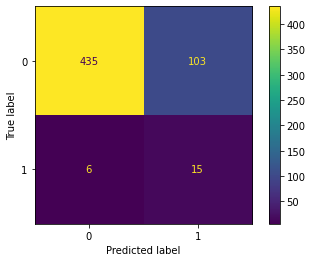

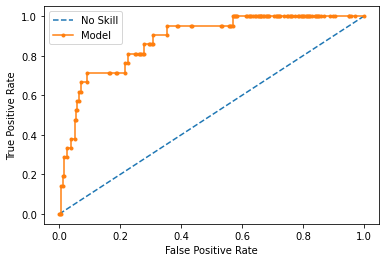

ROC AUC:  0.8806868472295981
Recall:  0.7141
Precision:  0.1272
Performance on test set using number of columns with maximum score
Diag: Major Depressive Disorder


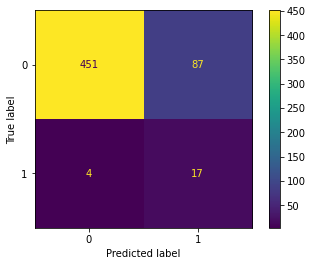

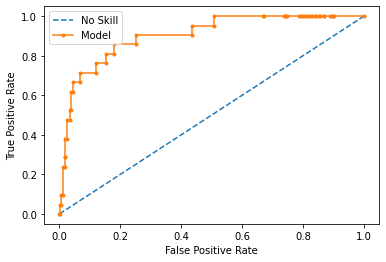

ROC AUC:  0.9039653035935564
Recall:  0.8092
Precision:  0.1635


In [40]:
# Print sfs results
for diag in forward_feature_objects.keys():
    print(diag)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[diag].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    classifier = best_classifiers[diag][0]
    threshold = best_thresholds[diag]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[input_cols], train_set[diag])
    print("Score using all features: ")
    metrics = get_metrics(new_classifier, threshold, diag, input_cols, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_optimal], train_set[diag])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_optimal, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_classifier = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), classifier[2])
    new_classifier.fit(train_set[features_up_to_max_score], train_set[diag])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_classifier, threshold, diag, features_up_to_max_score, 'test', 1)
    print("ROC AUC: ", metrics[-1])
    print("Recall: ", metrics[metric_names.index("Recall")])
    print("Precision: ", metrics[metric_names.index("Precision")])